In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import convolve2d
from skimage.restoration import denoise_bilateral
import cv2

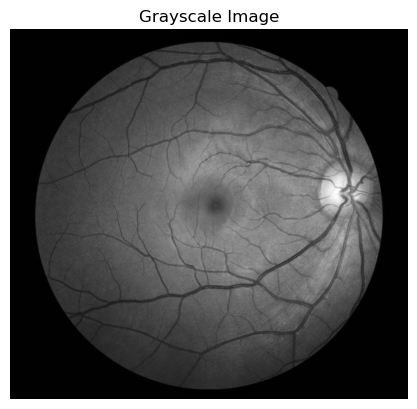

Max Intensity:  235
Min Intensity:  0


In [2]:
# Load the retinal fundus image in grayscale
image_path = 'Fundus.jpeg'
img = cv2.imread(image_path)
if img is None:
    raise IOError("Image not found. Check the image path.")

# Convert to RGB (OpenCV loads images in BGR format by default)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray_img, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')
plt.show()
print("Max Intensity: ",np.max(gray_img))
print("Min Intensity: ",np.min(gray_img))

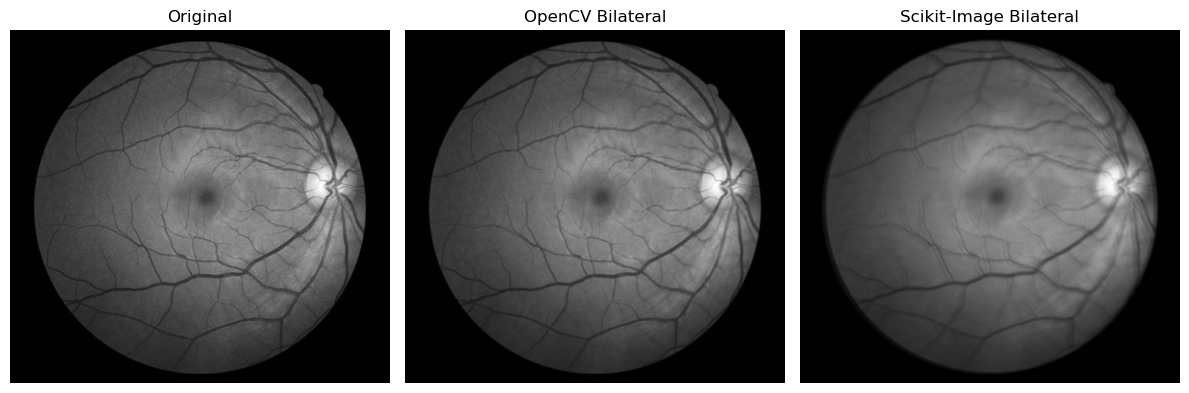

In [12]:
# Perform built-in bilateral (OpenCV)
gray_img_filtered = cv2.bilateralFilter(gray_img, d=5, sigmaColor=30, sigmaSpace=2)

# denoise_bilateral requires float image in [0,1]:
gray_img_float = gray_img.astype(np.float32) / np.max(gray_img)

# Built-in bilateral with scikit-image
bilat_skimage = denoise_bilateral(gray_img_float, sigma_color=20, sigma_spatial=2)
bilat_skimage = (bilat_skimage * 255).astype(np.float32)

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(gray_img, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.title("OpenCV Bilateral")
plt.imshow(gray_img_filtered, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Scikit-Image Bilateral")
plt.imshow(bilat_skimage, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
def histogram_equalization(gray_img):
    """

    Perform manual histogram equalization using these steps:
    1) Find maximum intensity value.
    2) Determine number of bits needed for max intensity.
    3) Compute histogram with maximum binary value.
    4) Compute cumulative frequency distribution (CFD).
    5) Normalize CFD by total pixels.
    6) Multiply by maximum intensity (based on binary bits).
    7) Round to nearest integer.
    8) Map old values to new values.

    """
    # 1) Find the maximum intensity value
    max_val = np.max(gray_img)

    # 2) Determine number of bits needed for max intensity
    bits_needed = int(max_val).bit_length()  # bit_length() gives the number of bits to represent max_val
    max_gray_level = (1 << bits_needed) - 1  # e.g. if bits=8, max_gray_level=255

    # 3) Compute histogram
    hist, bin_edges = np.histogram(gray_img, bins=np.arange(max_val+2))
    # hist[i] = number of pixels with intensity i

    # 4) Compute cumulative frequency distribution (CFD)
    cfd = np.cumsum(hist)  # cumulative sum

    # 5) Normalize CFD by total number of pixels
    total_pixels = gray_img.size
    cfd_normalized = cfd / total_pixels

    # 6) Multiply by the maximum intensity (based on the binary bits)
    # 7) Round to the nearest integer
    cfd_transformed = np.round(cfd_normalized * max_gray_level).astype('uint16')

    # 8) Map old values to new values
    lookup_table = cfd_transformed[:max_val+1]
    eq_img = lookup_table[gray_img]

    return eq_img, bits_needed, max_gray_level, hist, cfd, cfd_transformed

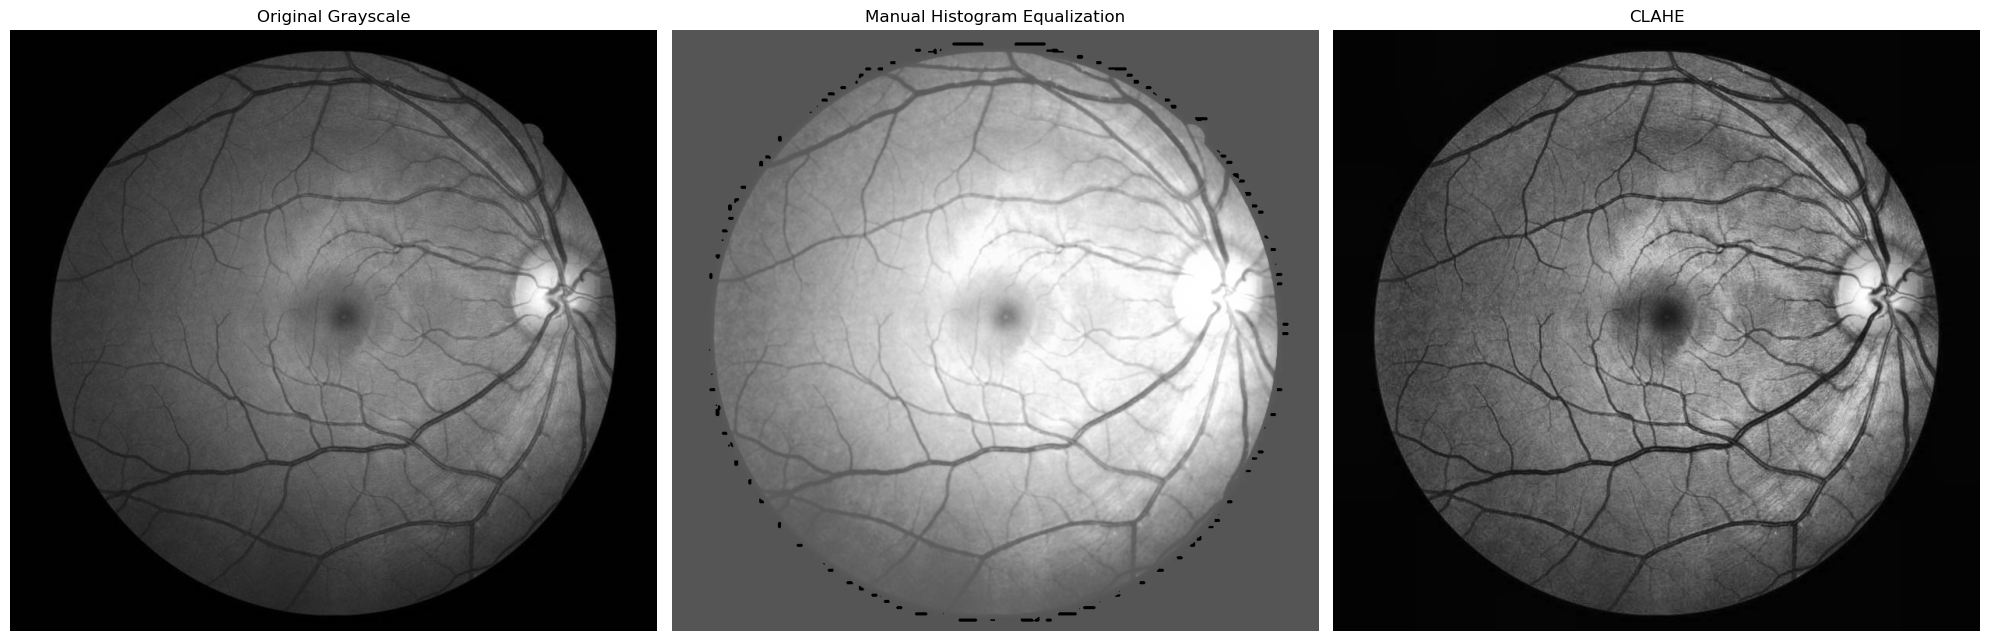

In [5]:
# Histogram Equalization
eq_img, bits_needed, max_gray_level, hist, cfd, cfd_transformed = histogram_equalization(gray_img_filtered)

# Create a CLAHE object for comparison
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clahe_img = clahe.apply(gray_img)

fig, axes = plt.subplots(1, 3, figsize=(20, 8))
# Original
axes[0].imshow(gray_img, cmap='gray')
axes[0].set_title("Original Grayscale")
axes[0].axis("off")

# Manual Histogram Equalized
axes[1].imshow(eq_img, cmap='gray')
axes[1].set_title("Manual Histogram Equalization")
axes[1].axis("off")

# CLAHE
axes[2].imshow(clahe_img, cmap='gray')
axes[2].set_title("CLAHE")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [6]:
def manual_scharr(gray_img):
    """
    Perform manual Scharr filtering using the 3x3 Scharr operator.
    Returns:
      I_x: gradient in x-direction
      I_y: gradient in y-direction
      magnitude: sqrt(I_x^2 + I_y^2)
      orientation: arctan(I_y / I_x), in radians
    """
    # Define Scharr kernels (float64 for accumulation)
    Gx = np.array([[-3, 0, 3],
                   [-10, 0, 10],
                   [ -3, 0, 3]], dtype=np.float64)

    Gy = np.array([[-3, -10, -3],
                   [ 0,   0,  0],
                   [ 3,  10,  3]], dtype=np.float64)

    # Convert image to float64 to avoid overflow in convolution
    img_float = gray_img.astype(np.float64)

    # Convolve with Gx and Gy
    # mode='same' ensures output is the same size as input
    # boundary='symm' handles boundaries by reflecting image
    I_x = convolve2d(img_float, Gx, mode='same', boundary='symm')
    I_y = convolve2d(img_float, Gy, mode='same', boundary='symm')

    # Compute gradient magnitude and orientation
    magnitude = np.sqrt(I_x**2 + I_y**2)
    orientation = np.arctan2(I_y, I_x)  # arctan2 handles sign of x,y

    return I_x, I_y, magnitude, orientation

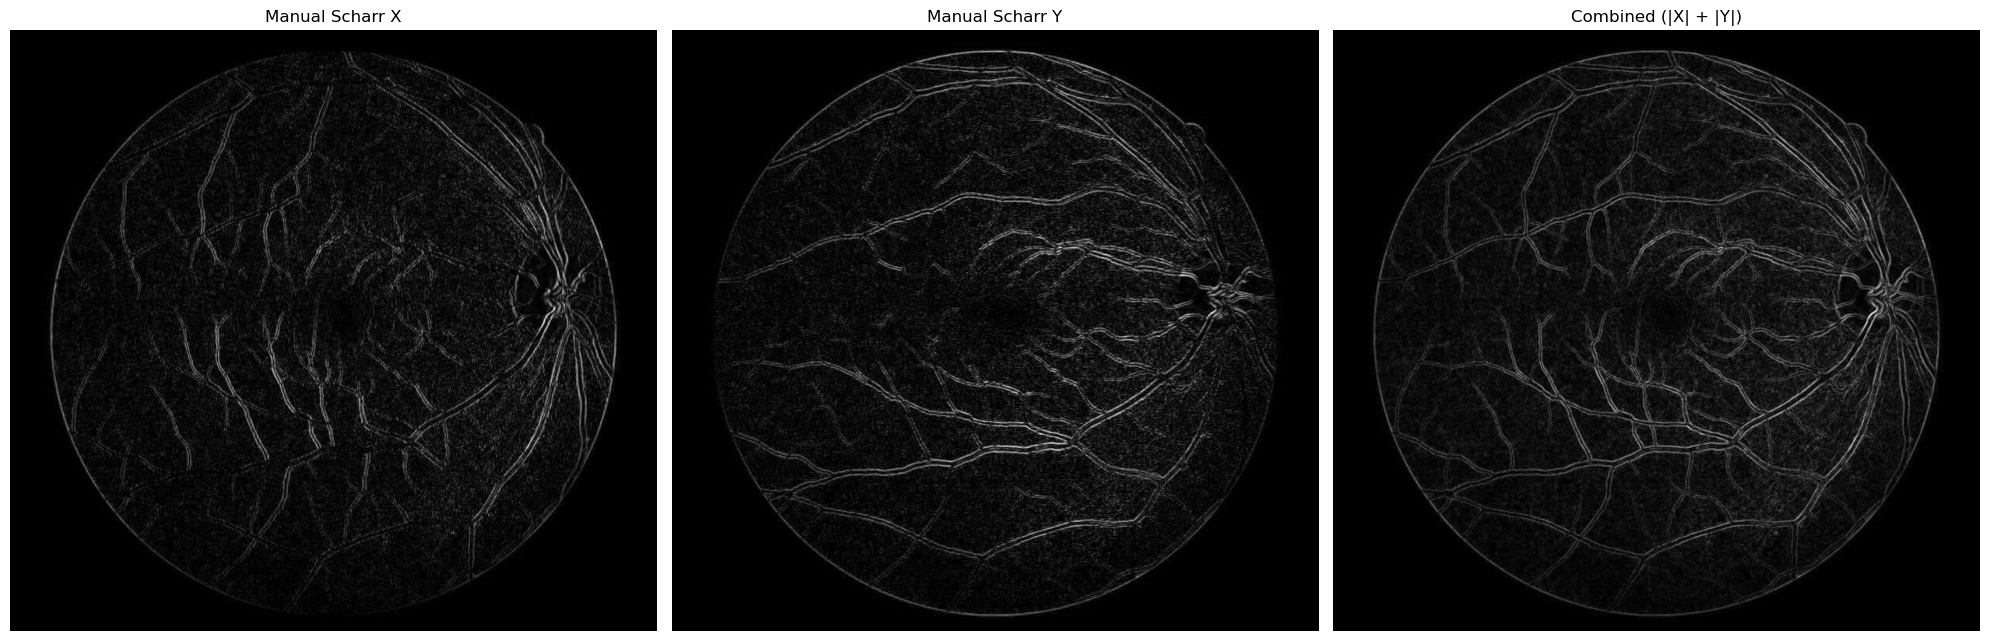

In [7]:
# Manual Scharr Filtering
I_x_manual, I_y_manual, mag_manual, orient_manual = manual_scharr(clahe_img)

# Scharr in X, Y: often contain negative values, so display absolute or scaled version
I_x_disp = np.uint8(255 * (np.abs(I_x_manual) / np.max(np.abs(I_x_manual))))
I_y_disp = np.uint8(255 * (np.abs(I_y_manual) / np.max(np.abs(I_y_manual))))

# Combined version using weighted sum of absolute values
combined = 0.5 * np.abs(I_x_manual) + 0.5 * np.abs(I_y_manual)
combined_disp = np.uint8(255 * (combined / np.max(combined)))

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# (a) Scharr X
axes[0].imshow(I_x_disp, cmap='gray')
axes[0].set_title('Manual Scharr X')
axes[0].axis('off')

# (b) Scharr Y
axes[1].imshow(I_y_disp, cmap='gray')
axes[1].set_title('Manual Scharr Y')
axes[1].axis('off')

# (c) Combined
axes[2].imshow(combined_disp, cmap='gray')
axes[2].set_title('Combined (|X| + |Y|)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [8]:
def create_LoG_kernel(kernel_size, sigma):
    """
    Create a Laplacian of Gaussian (LoG) kernel.

    Equation:
        LoG(x, y) = (1 / (pi * sigma^4)) * (1 - ((x^2 + y^2) / (2 * σ^2))) * exp(-(x² + y²) / (2σ²))

    Parameters:
        kernel_size (int): Size of the kernel (must be an odd number).
        sigma (float): Standard deviation of the Gaussian.

    Returns:
        numpy.ndarray: LoG kernel.
    """
    # Create coordinate grid centered at 0
    ax = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    norm2 = xx**2 + yy**2

    # Compute the LoG function
    factor = 1 / (np.pi * sigma**4)
    kernel = factor * (1 - norm2 / (2 * sigma**2)) * np.exp(-norm2 / (2 * sigma**2))

    # Normalize kernel to ensure zero-sum
    kernel_mean = kernel.mean()
    kernel = kernel - kernel_mean

    return kernel

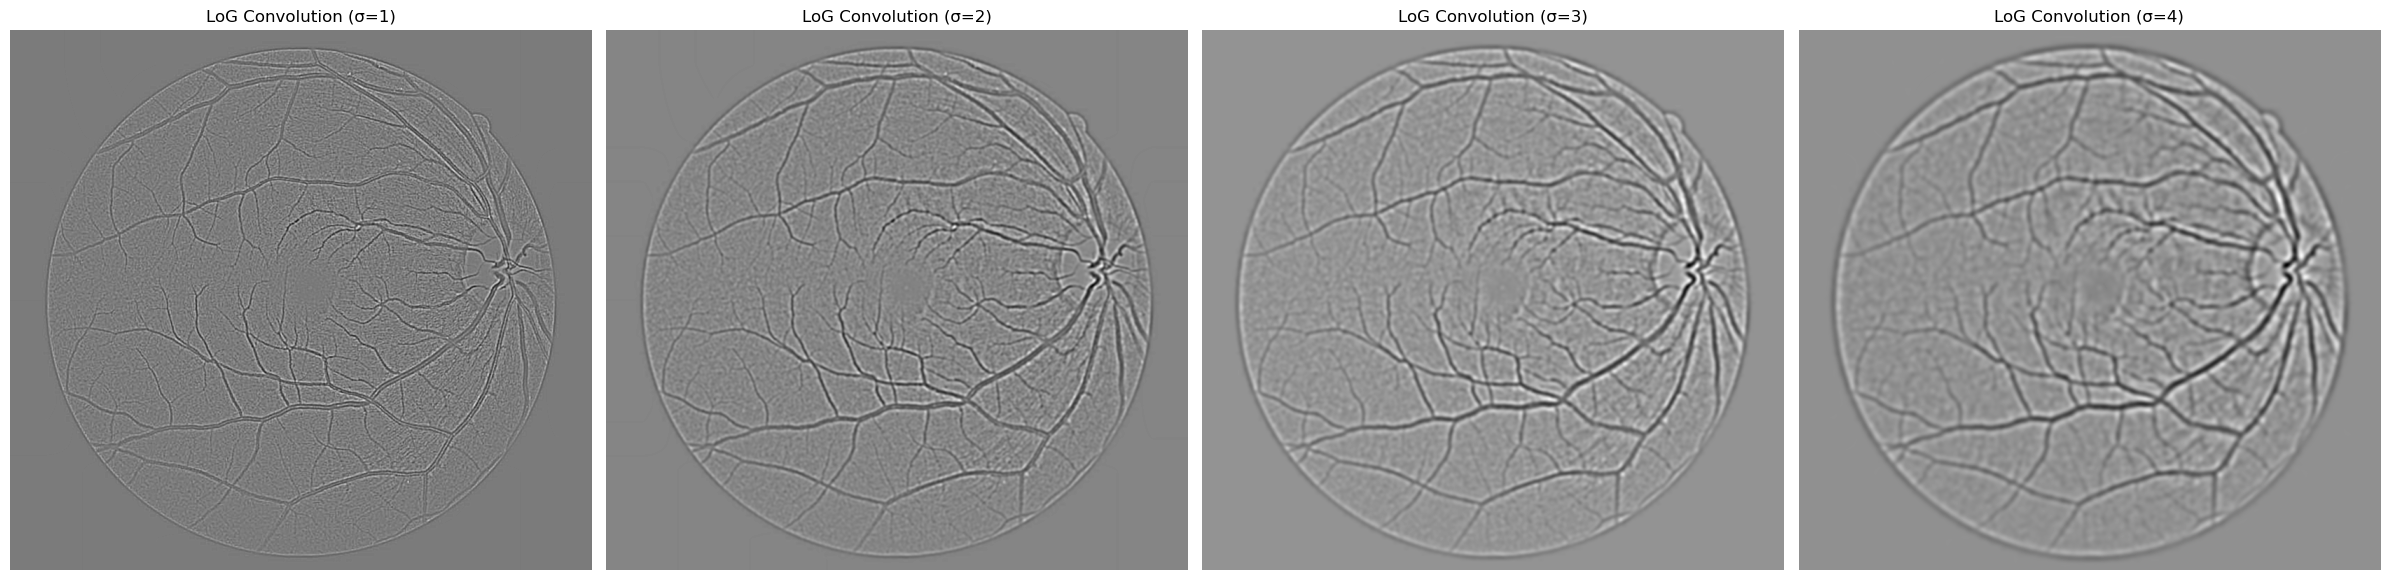

In [9]:
sigmas_LoG = [1, 2, 3, 4]
results_LoG = []  # to store convolved images for each sigma

for sigma in sigmas_LoG:
    kernel_size = int(np.ceil(6 * sigma + 1))  # typical rule of thumb
    kernel_LoG = create_LoG_kernel(kernel_size, sigma)

    # Convolve
    convolved_LoG = signal.convolve2d(clahe_img, kernel_LoG, boundary='symm', mode='same')

    # Normalize to [0, 255] for display
    # NOTE: LoG can have negative values; here we do a simple linear shift.
    min_val = convolved_LoG.min()
    max_val = convolved_LoG.max()
    convolved_LoG -= min_val
    if (max_val - min_val) > 1e-12:
        convolved_LoG *= (255.0 / (max_val - min_val))

    results_LoG.append((sigma, convolved_LoG))

# 3) Plot only the convolved images for each sigma
num_scales = len(sigmas_LoG)
fig, axes = plt.subplots(1, num_scales, figsize=(6 * num_scales, 10))

for i, (sigma, convolved_LoG) in enumerate(results_LoG):
    ax = axes[i] if num_scales > 1 else axes
    ax.set_title(f"LoG Convolution (σ={sigma})")
    ax.imshow(convolved_LoG, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
def create_Gaussian_kernel(kernel_size, sigma):
    """
    Create a 2D Gaussian kernel.

    Equation:
        G(x, y) = (1 / (2πσ²)) * exp(-(x² + y²) / (2σ²))

    Parameters:
        kernel_size (int): Size of the kernel (must be an odd number).
        sigma (float): Standard deviation of the Gaussian.

    Returns:
        numpy.ndarray: Gaussian kernel (2D).
    """
    ax = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
    xx, yy = np.meshgrid(ax, ax)
    norm2 = xx**2 + yy**2

    factor = 1.0 / (2.0 * np.pi * sigma**2)
    kernel = factor * np.exp(-norm2 / (2.0 * sigma**2))

    return kernel

In [11]:
def gaussian_smoothing(gray_img, sigma):
    """
    Smooth the image with a 2D Gaussian kernel of a given sigma.
    kernel_size is chosen as 6*sigma + 1 (typical rule).
    """
    kernel_size = int(np.ceil(6 * sigma) + 1)
    kernel = create_Gaussian_kernel(kernel_size, sigma)
    # Convolve the image with the kernel
    # Use boundary='symm' to mimic 'reflect' border mode
    smoothed = convolve2d(gray_img, kernel, mode='same', boundary='symm')
    return smoothed